Do sada smo diskutovali problem loše uslovljenih matrica i njihovu numeričku nestabilnost. U ovoj svesci upoznaćemo neke tehnike koje mogu da poprave korišćenje ovakvih matrica. Razmotrićemo primer rešavanja preuslovljenih sistema i grebene linearne regresije.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Tihonovljeva regularizacija

Posmatrajmo preodređeni sistem $Ax = b$. Ukoliko je matrica $A^TA$ loše uslovljena kod problema najmanjih kvadrata umesto rešavanja osnovnog problema $$min_{x} \|A\cdot x - b\|^2$$ može se rešavati problem $$min_{x} \|A\cdot x - b\|^2 + \alpha ||x||^2$$. Parametar $\alpha$ se zove regularizacioni parametar, a samo rešenje $x$ ima formu $x=(A^{T}A + \alpha I)^{-1}A^{T}b$. 

In [2]:
A = np.array([[1, 2], [2, 3.999]])
b = np.array([4, 7.999]).T

In [3]:
A

array([[1.   , 2.   ],
       [2.   , 3.999]])

In [4]:
def lstsq_solution(A, b):
    return np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)

In [5]:
x = lstsq_solution(A, b)

In [6]:
x

array([2.00000012, 0.99999998])

In [7]:
b1 = np.copy(b)
b1[0] =  b1[0] + 0.001 
b1[1] =  b1[1] - 0.001 

In [8]:
x1 = lstsq_solution(A, b1)

In [9]:
x1

array([-3.99899991,  4.        ])

## Grebena regresija

U kontekstu linearne regresije pri rešavanju sistema $A\beta = Y$ metodom najmanjih kvadrata, gde se minimizuje vrednost izraza $||Y - \beta A||_2^2$ i čije je rešenje dato u obliku $\beta=(A^{T}A)^{-1}A^{T}Y$ može se posmatrati regularizovana forma kojom se vrši minimizacija $||Y - \beta A||_2^2 + \alpha ||\beta||_2^2$ za pogodno izabran hiperparametar $\alpha$. Umesto linearne, tada se govori o grebenoj regresiji, a izraz $\alpha ||\beta||_2^2$ se naziva regularizacioni element.

Dalje ćemo na osnovu podataka u datoteci *hitters.csv* koji predstavljaju statistike o performansama bejzbol igrača, kreirati grebeni model koji može da predvidi visine njihovih plata. Demonstriraćemo i tehniku za određivanje optimalne vrednosti hiperparametara iz zadatog skupa koja koristi validacioni skup.

In [10]:
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection

Najpre učitajmo podatke i izvucimo osnovne informacije o njima.

In [11]:
data = pd.read_csv('data/hitters.csv')
data.shape

(322, 21)

In [12]:
data.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     322 non-null    object 
 1   AtBat      322 non-null    int64  
 2   Hits       322 non-null    int64  
 3   HmRun      322 non-null    int64  
 4   Runs       322 non-null    int64  
 5   RBI        322 non-null    int64  
 6   Walks      322 non-null    int64  
 7   Years      322 non-null    int64  
 8   CAtBat     322 non-null    int64  
 9   CHits      322 non-null    int64  
 10  CHmRun     322 non-null    int64  
 11  CRuns      322 non-null    int64  
 12  CRBI       322 non-null    int64  
 13  CWalks     322 non-null    int64  
 14  League     322 non-null    object 
 15  Division   322 non-null    object 
 16  PutOuts    322 non-null    int64  
 17  Assists    322 non-null    int64  
 18  Errors     322 non-null    int64  
 19  Salary     263 non-null    float64
 20  NewLeague 

Zaključujemo da postoji 322 unosa i 21 kolona. Od toga, jedino kod atributa `Salary` koji predstavlja plate bejzbol igrača imamo neke nedostajuće vrednosti. Pošto nam takvi unosi nisu relevantni, obrisaćemo ih (ukupno ima takvih 59 unosa).

In [14]:
data = data.dropna(axis=0)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     263 non-null    object 
 1   AtBat      263 non-null    int64  
 2   Hits       263 non-null    int64  
 3   HmRun      263 non-null    int64  
 4   Runs       263 non-null    int64  
 5   RBI        263 non-null    int64  
 6   Walks      263 non-null    int64  
 7   Years      263 non-null    int64  
 8   CAtBat     263 non-null    int64  
 9   CHits      263 non-null    int64  
 10  CHmRun     263 non-null    int64  
 11  CRuns      263 non-null    int64  
 12  CRBI       263 non-null    int64  
 13  CWalks     263 non-null    int64  
 14  League     263 non-null    object 
 15  Division   263 non-null    object 
 16  PutOuts    263 non-null    int64  
 17  Assists    263 non-null    int64  
 18  Errors     263 non-null    int64  
 19  Salary     263 non-null    float64
 20  NewLeague 

Sada nam je preostalo 263 unosa, bez nedostajućih vrednosti. Kolona *Salary* sadrži vrednosti koje želimo da predvidimo. Za vektor nezavisnih promenljivih, pored kolone *Salary*, potrebno je odbaciti sve one kolone koje nemaju numeričku vrednost. Među tim vrednostima su *Player*, *League*, *Division* i *NewLeague*.

In [16]:
y = data['Salary']

In [17]:
y.shape

(263,)

In [18]:
X = data.drop(['Player', 'League', 'Division', 'NewLeague', 'Salary'], axis=1)

In [19]:
X.shape

(263, 16)

Matricu nezavisnih promenljivih $X$ i vektor zavisnih promenljivih $y$ ćemo podeliti na skup za treniranje, skup za validaciju i skup za testiranje. Ideja je da na skupu za testiranje testiramo performanse naših modela, da validacioni skup iskoristimo za ocenu optimalne vrednosti regularizacionog parametra, a da skup za treniranje iskoristimo za samo treniranje modela. Razmera podele ovih skupova će biti 60%: 20%: 20%. Ovakva podela skup će pomoći da se izbegne problem preprilagodjavanja (engl. *overfitting*) modela podacima.

<img src='assets/train_validation_test.png'>

Za kreiranje ovih skupova možemo iskoristiti funkciju `train_test_split`. 

In [20]:
X_train_validation, X_test, y_train_valiadaion, y_test = model_selection.train_test_split(X, y, random_state=1, test_size=0.2)

In [21]:
X_train_validation.shape

(210, 16)

In [22]:
X_test.shape

(53, 16)

In [23]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X_train_validation, y_train_valiadaion, random_state=1, test_size=0.2)

In [24]:
X_train.shape

(168, 16)

In [25]:
X_validation.shape

(42, 16)

Nadalje možemo ispisati neke osnovne informacije o skupu za treniranje.

In [26]:
X_train.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,395.190476,105.452381,11.297619,54.404762,50.333333,41.636905,7.351190,2654.636905,720.601190,69.119048,360.773810,331.517857,264.767857,296.125000,113.244048,8.166667
std,145.587061,44.576088,8.295847,25.274123,25.092086,22.840878,4.667559,2162.381345,611.190045,81.343937,310.089608,318.013256,254.483720,280.709392,143.799282,6.473036
min,20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,41.000000,9.000000,0.000000,6.000000,7.000000,4.000000,0.000000,0.000000,0.000000
25%,278.750000,68.750000,5.000000,33.000000,30.000000,22.000000,4.000000,873.750000,210.000000,16.000000,111.750000,105.500000,85.000000,134.500000,7.000000,3.000000
50%,401.000000,103.000000,9.000000,50.500000,46.500000,37.000000,6.000000,1994.000000,530.000000,40.000000,257.000000,250.000000,188.000000,226.000000,43.500000,6.500000
75%,515.250000,138.000000,17.000000,72.000000,71.000000,59.250000,10.000000,3883.000000,1063.000000,92.250000,496.750000,446.500000,351.750000,325.000000,170.750000,12.250000
max,687.000000,213.000000,40.000000,130.000000,116.000000,105.000000,20.000000,9528.000000,2583.000000,548.000000,1509.000000,1659.000000,1380.000000,1320.000000,492.000000,32.000000


Možemo primetiti da su numeričke vrednosti podataka neuravnotežene. Za neke atribute je maksimalna vrednosti nekoliko desetina, a za druge i do nekoliko hiljada. Da bi mogli lakše da interpretiramo dobijene rezultate, podatke ćemo standardizovati tako što ćemo ih transformisati (po kolonama) tako da njihova srednja vrednost bude 0, a standardna devijacija 1. Osim ove svrhe, standardizacija podataka utiče na stabilnost i brzinu treniranja modela pa ju je poželjno uvek primenjivati. Za samu standardizaciju koristićemo klasu `StandardScaler` biblioteke `sklearn`. 

In [27]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

Funkcijom `fit` se izračunavaju srednje vrednosti i varijanse po kolonama. Važno je naglasiti da se funkcija `fit` poziva nad skupom za treniranje.

In [28]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

Zatim se ovako izračunate vrednosti koriste za transformaciju skupova. 

In [29]:
X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

Pogledajmo kako izgledaju metrike skupa nakon standardizacije po kolonama:

In [30]:
np.mean(X_train, axis=0)

array([-1.05735526e-16,  7.40148683e-17,  3.17206578e-17, -3.17206578e-17,
       -8.45884209e-17,  1.32169408e-16, -4.22942105e-17,  7.93016446e-17,
        1.85037171e-17, -2.11471052e-17,  5.28677631e-18, -5.28677631e-17,
       -8.45884209e-17,  2.11471052e-17,  1.05735526e-17,  1.05735526e-16])

In [31]:
np.std(X_train, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Sada možemo da odredimo model linearne regresije, a probaćemo i sa dva modela grebene regresije sa, na primer, parametrima $\alpha = 0.5$ i $\alpha = 10^{10}$. U sva tri slučaja, izračunaćemo i srednjekvadratnu grešku. Za grebenu regresiju se na nivou biblioteke koristi klasa `Ridge`. Način korišćenja je sličan načinu korišćenja klase `LinearRegression` uz dodatak vrednosti parametra $\alpha$.

In [32]:
linreg_model = linear_model.LinearRegression()
linreg_model.fit(X_train, y_train)
y_predict = linreg_model.predict(X_test)
score = metrics.mean_squared_error(y_test, y_predict)
score

144946.76529501542

In [33]:
ridge_model_1 = linear_model.Ridge(alpha=0.5)
ridge_model_1.fit(X_train, y_train)
y_predict = ridge_model_1.predict(X_test)
score = metrics.mean_squared_error(y_test, y_predict)
score

129522.03310940904

In [34]:
ridge_model_2 = linear_model.Ridge(alpha=10**10, normalize=True)
ridge_model_2.fit(X_train, y_train)
y_predict = ridge_model_2.predict(X_test)
score = metrics.mean_squared_error(y_test, y_predict)
score

229101.7742251828

Vidimo da u prvom slučaju grebena regresija daje bolji rezultat od linearne, a u drugom nešto lošiji. Ovo nas motiviše da razmotrimo različite vrednosti parametra $\alpha$. Ispitaćemo 100 različitih vrednosti između $10^{-3}$ i $10^{10}$ (razmatramo različite redove veličine).

In [35]:
alphas = 10 ** np.linspace(-3, 10, 100)

Zatim ćemo za svaku vrednost parametra $\alpha$ odrediti grebeni model i oceniti njegovu srednjekvadratnu grešku na validacionom skupu. Dobijene greške ćemo čuvati u posebnom nizu za dalju analizu. 

In [36]:
errors = np.empty(0)

for a in alphas:
    reg = linear_model.Ridge(normalize=True, alpha=a)
    reg.fit(X_train, y_train)
    y_predict = reg.predict(X_validation)
    error = metrics.mean_squared_error(y_predict, y_validation)
    errors = np.append(errors, error)

Nacrtajmo grafik zavisnosti greške u od parametra $\alpha$. Zbog načina izbora parametra $\alpha$ tj. opsega vrednosti koje uzima, iskoristićemo logaritamsku skalu zarad bolje preglednosti. 

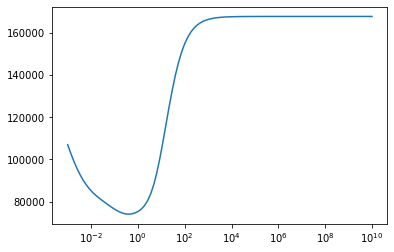

In [37]:
plt.plot(alphas, errors)
plt.xscale('log')
plt.show()

Za finalnu vrednost parametra $\alpha$ odabraćemo onu koju model ima najmanju grešku.

In [38]:
optimal_alpha = alphas[errors.argmin()]

In [39]:
optimal_alpha

0.4229242874389499

Sada možemo odrediti konačan model i dati ocenu njegove greške na skupu za testiranje.

In [40]:
final_model = linear_model.Ridge(alpha=optimal_alpha)
final_model.fit(X_train, y_train)
y_predict = final_model.predict(X_test)
score = metrics.mean_squared_error(y_test, y_predict)
score

130077.95071405025

Možemo ispisati i koeficijent determinacije našeg modela. On ukazuje da postoji još puno prostora za poboljšanje našeg modela.

In [41]:
metrics.r2_score(y_test, y_predict)

0.43205489919713036

Kada pristignu podaci o novom igraču, model možemo iskoristiti za predikciju. U našem slučaju su novi podaci nasumični celi brojevi. Važno je napomenuti da pre nego li se izvrši predikcija modela, nove podatke treba standardizovati.

In [44]:
new_player_data = np.random.randint(0, 100, X.shape[1])
new_player_data = scaler.transform([new_player_data])
new_player_salary = final_model.predict(new_player_data)

In [45]:
print('Plata novog igraca: ', new_player_salary)

Plata novog igraca:  [1020.41903638]
